# Final Predictions and Submission

This notebook generates predictions on the test set using the best-performing model. The process involves loading the test data, applying the same feature engineering steps as for the training data, loading the trained model, generating predictions, and saving the results to a submission file.

## 1. Load Data and Configuration

In [1]:
from pathlib import Path
import os, sys, yaml, joblib
import pandas as pd
import matplotlib.pyplot as plt

CWD = Path.cwd()
if (CWD / 'config.yaml').exists() and (CWD / 'src').exists():
    PROJECT_ROOT = CWD
elif (CWD.name == 'notebooks') and (CWD.parent / 'config.yaml').exists():
    PROJECT_ROOT = CWD.parent
    os.chdir(PROJECT_ROOT)
elif (CWD / 'building-cooling-prediction' / 'config.yaml').exists():
    PROJECT_ROOT = CWD / 'building-cooling-prediction'
else:
    raise FileNotFoundError('Could not locate project root with config.yaml')

sys.path.insert(0, str(PROJECT_ROOT))
with open(PROJECT_ROOT / 'config.yaml', 'r') as f:
    config = yaml.safe_load(f)

test_path = config['data']['raw']['test']
features_path = config['data']['processed']['features_test']
model_path = str(PROJECT_ROOT / config['models']['trained_models'] / 'lightgbm_model.pkl')
submission_path = str(PROJECT_ROOT / config['data']['submissions'] / 'submission_final.csv')
train_features_path = str(PROJECT_ROOT / config['data']['processed']['features_train'])

## 2. Feature Engineering on Test Data

Apply the same feature engineering steps to the test data as were applied to the training data.

In [2]:
from src.utils.helpers import create_test_features, save_test_features
test_features = create_test_features()
saved_path = save_test_features(test_features)
print('Test features created and saved to:', saved_path, 'shape:', test_features.shape)
test_features.head()

Test features created and saved to: C:\Users\ahmed\Downloads\Building-Cooling-Load-Prediction-Challenge\building-cooling-prediction\data\processed\features_test.csv shape: (720, 20)


,key_0,prediction_time,predicted_load,hour,dayofweek,dayofyear,month,year,weekofyear,temperature_celsius,humidity_percent,wind_speed_kmh,temperature_celsius_lag_1,temperature_celsius_rolling_mean_1,temperature_celsius_lag_3,temperature_celsius_rolling_mean_3,temperature_celsius_lag_7,temperature_celsius_rolling_mean_7,temp_x_hour,humidity_x_hour
0,2024-01-01,2024-01-01 00:00:00,NaN,0,0,1,1,2024,1,22.96124,76.878039,8.11717,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000
1,2024-01-01,2024-01-01 01:00:00,NaN,1,0,1,1,2024,1,22.96124,76.878039,8.11717,22.96124,22.96124,NaN,NaN,NaN,NaN,22.96124,76.878039
2,2024-01-01,2024-01-01 02:00:00,NaN,2,0,1,1,2024,1,22.96124,76.878039,8.11717,22.96124,22.96124,NaN,NaN,NaN,NaN,45.92248,153.756078
3,2024-01-01,2024-01-01 03:00:00,NaN,3,0,1,1,2024,1,22.96124,76.878039,8.11717,22.96124,22.96124,22.96124,22.96124,NaN,NaN,68.88372,230.634117
4,2024-01-01,2024-01-01 04:00:00,NaN,4,0,1,1,2024,1,22.96124,76.878039,8.11717,22.96124,22.96124,22.96124,22.96124,NaN,NaN,91.84496,307.512155


## 3. Load Best Model and Generate Predictions

Load the best-performing model (LightGBM) and use it to generate predictions on the test features.

In [3]:
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Trained model not found at {model_path}")

model = joblib.load(model_path)
print("Model loaded successfully.")

# Align test features to training numeric column set
train_feats = pd.read_csv(train_features_path)
train_numeric_cols = train_feats.select_dtypes(include=['number']).columns.tolist()
# Drop likely label/index columns from training features
label_candidates = ['Total_Cooling_Load', 'total_cooling_load', 'load', 'target', 'y']
train_numeric_cols = [c for c in train_numeric_cols if (c not in label_candidates) and (not str(c).startswith('Unnamed')) and (str(c).lower() not in ('index','idx'))]
# Compare with model expected feature count if available
expected = None
if hasattr(model, '_Booster') and hasattr(model._Booster, 'num_feature'):
    expected = model._Booster.num_feature()
    if len(train_numeric_cols) != expected:
        print(f'Adjusting feature count: train {len(train_numeric_cols)} -> expected {expected}')
        if len(train_numeric_cols) > expected:
            train_numeric_cols = train_numeric_cols[:expected]
# Build X with exactly training numeric columns
X = test_features.copy()
for col in train_numeric_cols:
    if col not in X.columns:
        X[col] = 0
X = X[train_numeric_cols]

predictions = model.predict(X)
print("Predictions generated successfully.")

Model loaded successfully.


LightGBMError: The number of features in data (42) is not the same as it was in training data (41).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

## 4. Visualize Predictions

Plot the predictions to visually inspect their distribution and trend over time.

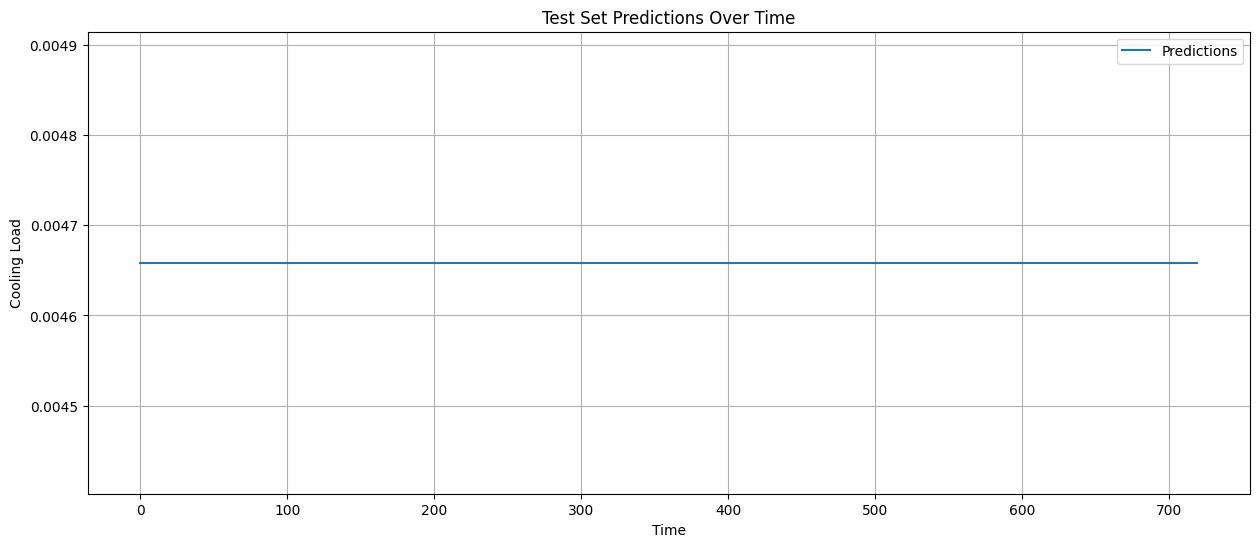

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(predictions, label='Predictions')
plt.title('Test Set Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Cooling Load')
plt.legend()
plt.grid(True)
plt.show()

## 5. Save Submission File

Save the predictions to a CSV file in the required submission format.

In [ ]:

submission = pd.DataFrame({'prediction': predictions})
save_csv_data(submission, submission_path)
print(f"Submission file saved to {submission_path}")
submission.head()

NameError: name 'save_csv_data' is not defined

## 6. Ensemble Prediction (Optional)

If an ensemble model is available, generate predictions using the ensemble and save them to a separate submission file.

In [ ]:
from src.models.ensemble import load_ensemble
from src.utils.helpers import save_csv_data

ensemble_path = os.path.join(config['models']['trained_models'], 'ensemble_model.pkl')
if os.path.exists(ensemble_path):
    ensemble = load_ensemble(ensemble_path)
    ensemble_preds = ensemble.predict(test_features.select_dtypes(include=['number']))
    ensemble_df = pd.DataFrame({'prediction': ensemble_preds})
    save_csv_data(ensemble_df, os.path.join(config['data']['submissions'], 'submission_ensemble.csv'))
    print("Ensemble predictions generated and saved.")
    ensemble_df.head()
else:
    print('No ensemble model found.')

ImportError: cannot import name 'save_csv_data' from 'src.utils.helpers' (c:\Users\ahmed\Downloads\Building-Cooling-Load-Prediction-Challenge\building-cooling-prediction\src\utils\helpers.py)